In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
from sklearn.metrics import classification_report

# For CNN Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *

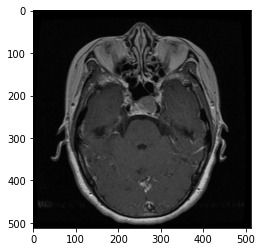

In [8]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
train_data = []

train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'

for category in categories:
    category_path = os.path.join(train_dir, category)
    for img in os.listdir(category_path):
        img_arr = cv2.imread(os.path.join(category_path,img))
#         print(os.path.join(category_path,img))
    
plt.imshow(img_arr)

In [9]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

data_paths = []
data_labels = []

def create_training_dataset():
    for label in os.listdir(train_dir):
        for img in os.listdir(train_dir+label):
            data_paths.append(train_dir+label+'/'+img)
            data_labels.append(label)
        
            
create_training_dataset()

In [10]:
#data shuffle
from sklearn.utils import shuffle
data_paths, data_labels = shuffle(data_paths, data_labels, random_state=42)

In [11]:
len_train = int(0.8*len(data_paths))
train_paths = data_paths[0:len_train]
train_labels = data_labels[0:len_train]

val_paths = data_paths[len_train:]
val_labels = data_labels[len_train:]

In [ ]:
test_paths = []
test_labels = []

def create_testing_dataset():
    for label in os.listdir(test_dir):
        for image in os.listdir(test_dir+label):
            test_paths.append(test_dir+label+'/'+image)
            test_labels.append(label)
        
create_testing_dataset()

In [14]:
len(test_paths)

1311

In [15]:
test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

In [16]:
brain_tumor_classes = os.listdir(train_dir)
brain_tumor_classes 

['pituitary', 'notumor', 'meningioma', 'glioma']

In [17]:
def encode_labels(labels):
    encoded_labels = []
    for label in labels:
        encoded_labels.append(brain_tumor_classes.index(label))
    return np.asarray(encoded_labels)

def decode_labels(encoded_labels):
    decoded_labels = []
    for label in encoded_labels:
        decoded_labels.append(brain_tumor_classes[label])
    return np.asarray(decoded_labels)

In [18]:
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance

IMG_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMG_SIZE,IMG_SIZE))
        image = Image.fromarray(np.uint8(image))
        image = np.array(image)/255.0
        images.append(image)
    return  np.array(images)



In [56]:
model = Sequential()
model.add(Conv2D(filters=64,kernel_size=(10,10),strides=(1, 1)
                 ,padding='valid',input_shape=(128, 128, 3)))
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2, 2),strides=None,padding='valid'))#####
model.add(Conv2D(filters=128,kernel_size=3,strides=(1, 1),padding='same'))#####
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2, 2),strides=None,padding="valid"))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128,kernel_size=2,strides=(1, 1),padding='same'))#####
model.add(ReLU(0.01))
model.add(MaxPool2D(pool_size=(2, 2),strides=None,padding='valid'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(4,activation="softmax")) # 4 outputs 

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 119, 119, 64)      19264     
_________________________________________________________________
re_lu_6 (ReLU)               (None, 119, 119, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
re_lu_7 (ReLU)               (None, 59, 59, 128)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 29, 29, 128)      

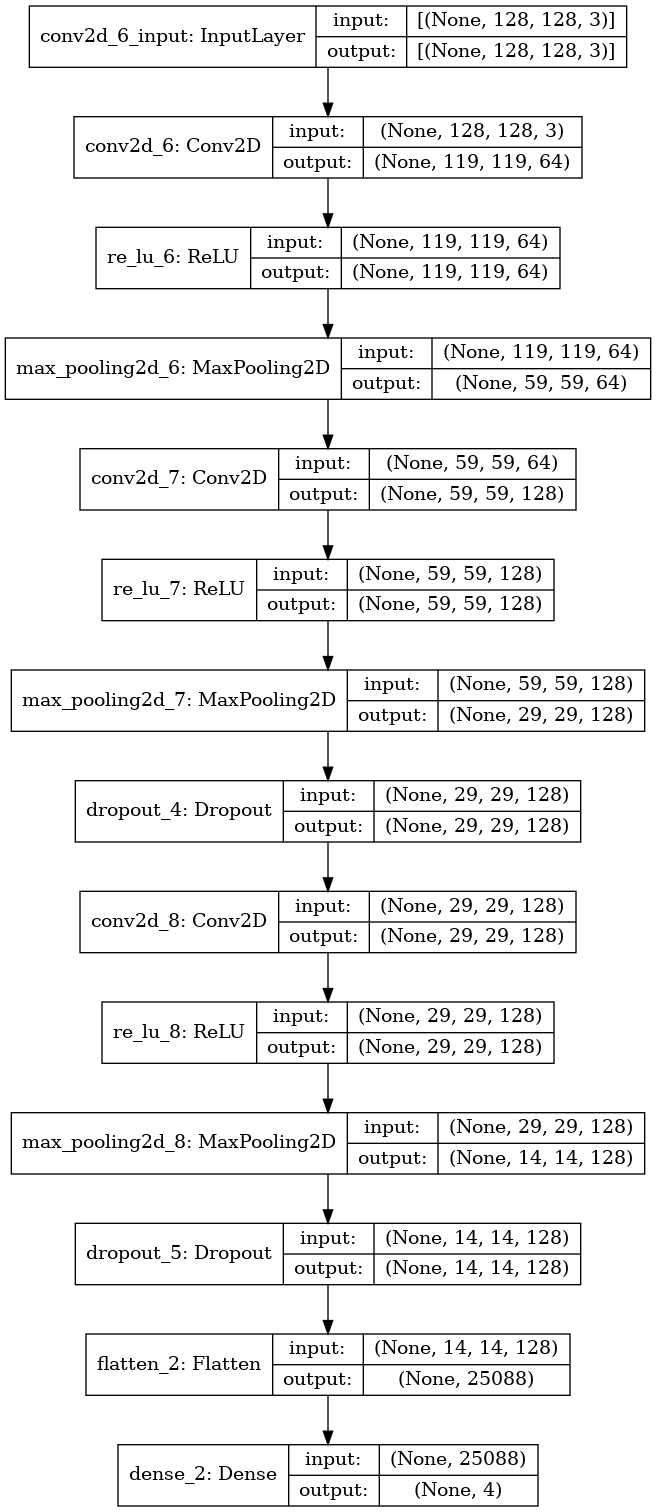

In [58]:
keras.utils.plot_model(model, show_shapes=True)

In [59]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [60]:

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_labels(batch_labels)
            yield batch_images, batch_labels 

In [75]:

epochs = 100
batch_size = 128
steps = int(len(train_paths)/batch_size)

test_data = datagen(
    test_paths,
    test_labels,
    batch_size=batch_size,
    epochs=epochs)

test_data

<generator object datagen at 0x7fe37850e950>

In [76]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, 
                            epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps, 
                    validation_data=datagen(val_paths, val_labels, 
                                            batch_size=batch_size, epochs=epochs), 
                    callbacks=[callback])

Epoch 1/100
35/35 [==============================] - 408s 12s/step - loss: 0.2288 - sparse_categorical_accuracy: 0.9281 - val_loss: 0.2596 - val_sparse_categorical_accuracy: 0.9151
Epoch 2/100
35/35 [==============================] - 15s 444ms/step - loss: 0.2177 - sparse_categorical_accuracy: 0.9329
Epoch 3/100
35/35 [==============================] - 16s 449ms/step - loss: 0.2125 - sparse_categorical_accuracy: 0.9340
Epoch 4/100
35/35 [==============================] - 15s 434ms/step - loss: 0.2091 - sparse_categorical_accuracy: 0.9363
Epoch 5/100
35/35 [==============================] - 16s 457ms/step - loss: 0.2022 - sparse_categorical_accuracy: 0.9379
Epoch 6/100
35/35 [==============================] - 15s 441ms/step - loss: 0.1994 - sparse_categorical_accuracy: 0.9379
Epoch 7/100
35/35 [==============================] - 16s 453ms/step - loss: 0.1932 - sparse_categorical_accuracy: 0.9403
Epoch 8/100
35/35 [==============================] - 15s 436ms/step - loss: 0.1904 - sparse_c

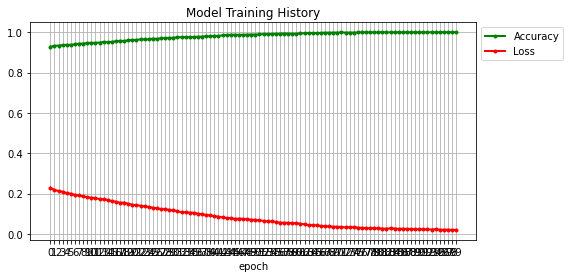

In [77]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [78]:
from tqdm import tqdm


y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_labels(pred):
        y_pred.append(i)
    for i in decode_labels(y):
        y_true.append(i)

 31%|███▏      | 11/35 [00:04<00:10,  2.23it/s]


In [79]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.93      0.93      0.93       300
  meningioma       0.92      0.81      0.86       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.93      1.00      0.96       300

    accuracy                           0.94      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



In [80]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [83]:
model.save('model.h5')

In [84]:
from IPython.display import FileLink
FileLink("./model.h5")

/kaggle/working/model.h5

In [85]:
tf.math.confusion_matrix(
    labels = y,
    predictions = pred,
    num_classes=4)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[5, 0, 1, 0],
       [0, 8, 0, 0],
       [0, 1, 6, 0],
       [0, 0, 1, 9]], dtype=int32)>

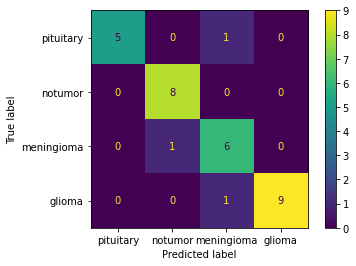

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=brain_tumor_classes)
disp.plot()